In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios


In [29]:
#pip install gapminder
#pip install formulaic

## Sistemas de ecuaciones lineales

Sabemos que un fonde de inversión invirtió en acciones de YPF, Santander y Nvidia (y solo en estas acciones) pero no sabemos cuántas acciones compró de cada una. ¿Cómo podemos averiguarlo? La única información que tenemos disponible es la valorización del fondo al final de cada día. 

Podemos conseguir información del valor de cada acción al cierre de cada día. Ponemos toda la información en la siguiente tabla.

In [77]:
dataDict = {'total': [170262,169929.5,171064,169637.35,164625.45], 
        'YPF': [20935, 21030, 20770, 20950, 20750], 
        'Santander': [20100, 20500, 21700, 21000, 20316], 
        'Nvidia': [37100, 36255, 36000, 35645.5, 33878.5]}
data = pd.DataFrame.from_dict(dataDict)
data

,total,YPF,Santander,Nvidia
0,170262.00,20935,20100,37100.0
1,169929.50,21030,20500,36255.0
2,171064.00,20770,21700,36000.0
3,169637.35,20950,21000,35645.5
4,164625.45,20750,20316,33878.5


Nos quedamos con las primeras tres filas y resolvemos el sistema lineal:
$$total = c_1 \cdot YPF + c_2 \cdot Santander + c_3 \cdot Nvidia$$


In [35]:
data3 = data[[True, True, True, False, False]]
data3

,total,YPF,Santander,Nvidia
0,170262.0,20935,20100,37100.0
1,169929.5,21030,20500,36255.0
2,171064.0,20770,21700,36000.0


In [36]:
X = data3[["YPF", "Santander", "Nvidia"]]
y = data3["total"]
display(X)
display(y)

,YPF,Santander,Nvidia
0,20935,20100,37100.0
1,21030,20500,36255.0
2,20770,21700,36000.0


0    170262.0
1    169929.5
2    171064.0
Name: total, dtype: float64

Para obtener los valores de c_1, c_2 y c_3 resolvemos el sistema lineal utilizando np.linalg.solve

In [25]:
np.linalg.solve(X, y)

array([3.2, 2. , 1.7])

**Pregunta** A partir de la respuesta, podemos confirmar que este fondo tenía estas 3 acciones?

In [37]:
# Incorporamos una nueva columna al dataframe
data["BBVA"] = np.array([20100, 19400, 21900, 20600, 20900])
data

,total,YPF,Santander,Nvidia,BBVA
0,170262.00,20935,20100,37100.0,20100
1,169929.50,21030,20500,36255.0,19400
2,171064.00,20770,21700,36000.0,21900
3,169637.35,20950,21000,35645.5,20600
4,164625.45,20750,20316,33878.5,20900


In [39]:
data3 = data[[True, True, True, False, False]]
X = data3[["YPF", "BBVA", "Nvidia"]]
y = data3["total"]
np.linalg.solve(X, y)

array([6.69507872, 1.16828332, 0.17838362])

Un sistema de 3x3 en general va a tener solución (única), no nos sirve para ver si nuestro "modelo" es correcto.
Podemos hacer dos cosas:
    
1. Verificar la formula obtenida en los dias siguientes.
2. Utilizar todos los días disponibles para encontrar los coeficientes.

Para el método 1 separamos nuestro DataFrame en dos: conjunto de entrenamiento (las primeras 3 filas) y conjunto de testeo (las últimas 2 filas).

In [60]:
data_train = data[[True, True, True, False, False]]
data_test = data[[False, False, False, True, True]]

In [61]:
# Entrenamos el primer modelo  (usando la variable Santander)
X_train = data_train[["YPF", "Santander", "Nvidia"]]
y_train = data_train["total"]
c = np.linalg.solve(X_train, y_train)
c

array([3.2, 2. , 1.7])

In [62]:
# Verificamos si nuestro modelo "predice" bien en el conjunto de testeo:
X_test = data_test[["YPF", "Santander", "Nvidia"]]
y_test = data_test["total"]
X_test @ c - y_test # Errores

3    0.0
4    0.0
dtype: float64

In [63]:
# Repetimos con el modelo BBVA.

# Entrenamos el modelo
X_train = data_train[["YPF", "BBVA", "Nvidia"]]
y_train = data_train["total"]
c = np.linalg.solve(X_train, y_train)
c

array([6.69507872, 1.16828332, 0.17838362])

In [64]:
# Verificamos si nuestro modelo "predice" bien en el conjunto de testeo:
X_test = data_test[["YPF", "BBVA", "Nvidia"]]
y_test = data_test["total"]
X_test @ c - y_test # Errores

3    1049.758866
4    4757.924263
dtype: float64

Comparando los errores en ambos modelos, vemos que en el primer modelo los errores en las predicciones son mucho menores, por lo tanto elegimos el modelo 1.

**Pregunta.** En este ejemplo, cual de los dos modelos tiene errores menores en el ajuste de los datos de entrenamiento?

Ahora consideramos 10 días, y utilizamos los 8 primeros para entrenar el modelo.

In [75]:
dataDict = {'total': [166650.00, 167756.00, 167981.00, 168597.00, 168796.00, 170262,169929.5,171064,169637.35,164625.45], 
        'YPF': [20100, 20230, 20300, 20410, 20500, 20935, 21030, 20770, 20950, 20750], 
        'Santander': [19800, 19890, 19950, 20150, 20080, 20100, 20500, 21700, 21000, 20316], 
        'Nvidia': [36900, 37200, 37130, 37050, 37080, 37100, 36255, 36000, 35645.5, 33878.5], 
        'BBVA': [23000, 22900, 21800, 21100, 20750, 20100, 19400, 21900, 20600, 20900]}
data = pd.DataFrame.from_dict(dataDict)
data

,total,YPF,Santander,Nvidia,BBVA
0,166650.00,20100,19800,36900.0,23000
1,167756.00,20230,19890,37200.0,22900
2,167981.00,20300,19950,37130.0,21800
3,168597.00,20410,20150,37050.0,21100
4,168796.00,20500,20080,37080.0,20750
5,170262.00,20935,20100,37100.0,20100
6,169929.50,21030,20500,36255.0,19400
7,171064.00,20770,21700,36000.0,21900
8,169637.35,20950,21000,35645.5,20600
9,164625.45,20750,20316,33878.5,20900


In [ ]:
data_train = data[[True, True, True, False, False]]
data_test = data[[False, False, False, True, True]]

In [ ]:
# 1. Verificamos el modelo 1 utilizando los 5 días
X = data[["YPF", "BBVA", "Nvidia"]]
y = data["total"]
scipy.linalg.solve(X, y)

In [44]:
# Solve nos da error, solo acepta matrices cuadradas, porque un sistema con mas filas en general no tiene solución.
X = data[["YPF", "BBVA", "Nvidia"]]
y = data["total"]
scipy.linalg.lstsq(X, y)

(array([3.65974477, 1.12170056, 1.94486441]),
 2518304.63911484,
 3,
 array([103448.94840066,   2310.97041946,    840.81687583]))

# Caso de estudio: calorías de alimentos

In [84]:
df_comida = pd.read_csv('../data/nutrition.csv')
df_comida

,FDC_ID,Item,Category,Calorias_kcal,Proteinas_g,Carbohidratos_g,GrasaTotal_g,Colesterol_mg,Fibra_g,Agua_g,Alcohol_g,VitaminaC_mg
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",Baked Products,307.0,5.88,41.18,13.24,0.0,1.2,35.50,NaN,NaN
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",Baked Products,330.0,4.34,53.42,11.27,0.0,1.4,27.86,NaN,0.1
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",Baked Products,377.0,6.10,79.80,3.70,NaN,NaN,3.20,NaN,NaN
3,167515,"George Weston Bakeries, Thomas English Muffins",Baked Products,232.0,8.00,46.00,1.80,NaN,NaN,42.60,NaN,NaN
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",Baked Products,273.0,6.58,41.05,9.22,15.0,2.2,40.34,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7788,175300,"Game meat, buffalo, water, cooked, roasted","Lamb, Veal, and Game Products",131.0,26.83,0.00,1.80,61.0,0.0,68.81,NaN,0.0
7789,175301,"Game meat, elk, raw","Lamb, Veal, and Game Products",111.0,22.95,0.00,1.45,55.0,0.0,74.38,NaN,0.0
7790,175302,"Game meat, elk, cooked, roasted","Lamb, Veal, and Game Products",146.0,30.19,0.00,1.90,73.0,0.0,66.28,NaN,0.0
7791,175303,"Game meat, goat, raw","Lamb, Veal, and Game Products",109.0,20.60,0.00,2.31,57.0,0.0,75.84,NaN,0.0


Vemos que el DataFrame contiene muchos datos "NaN" (not a number). 

En este ejemplo consideramos que los datos faltantes representan que el alimento no contiene ese ingrediente y lo convertimos a 0.

In [87]:
# Utilizamos fillna para convertir NaN a 0.
df_comida = df_comida.fillna(0)

In [89]:
df_comida.head()

,FDC_ID,Item,Category,Calorias_kcal,Proteinas_g,Carbohidratos_g,GrasaTotal_g,Colesterol_mg,Fibra_g,Agua_g,Alcohol_g,VitaminaC_mg
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",Baked Products,307.0,5.88,41.18,13.24,0.0,1.2,35.50,0.0,0.0
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",Baked Products,330.0,4.34,53.42,11.27,0.0,1.4,27.86,0.0,0.1
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",Baked Products,377.0,6.10,79.80,3.70,0.0,0.0,3.20,0.0,0.0
3,167515,"George Weston Bakeries, Thomas English Muffins",Baked Products,232.0,8.00,46.00,1.80,0.0,0.0,42.60,0.0,0.0
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",Baked Products,273.0,6.58,41.05,9.22,15.0,2.2,40.34,0.0,0.0


Construimos las matrices X e y utilizando Formulaic

In [121]:
y, X = (
    Formula('Calorias_kcal ~ Proteinas_g + Carbohidratos_g + GrasaTotal_g + Colesterol_mg + Fibra_g + Agua_g + Alcohol_g + VitaminaC_mg')
    .get_model_matrix(df_comida)
)

In [122]:
X.head()

,Intercept,Proteinas_g,Carbohidratos_g,GrasaTotal_g,Colesterol_mg,Fibra_g,Agua_g,Alcohol_g,VitaminaC_mg
0,1.0,5.88,41.18,13.24,0.0,1.2,35.50,0.0,0.0
1,1.0,4.34,53.42,11.27,0.0,1.4,27.86,0.0,0.1
2,1.0,6.10,79.80,3.70,0.0,0.0,3.20,0.0,0.0
3,1.0,8.00,46.00,1.80,0.0,0.0,42.60,0.0,0.0
4,1.0,6.58,41.05,9.22,15.0,2.2,40.34,0.0,0.0


In [123]:
y.head()

,Calorias_kcal
0,307.0
1,330.0
2,377.0
3,232.0
4,273.0


**Observación**

En este caso sencillo, podemos obtener lo mismo (excepto por la columna Intercept) utilizando una lista de columnas.


In [93]:
#X = df_comida[["Proteinas_g", "Carbohidratos_g", "GrasaTotal_g", "Colesterol_mg","Fibra_g", "Agua_g","Alcohol_g","VitaminaC_mg"]]
#y = df_comida["Calorias_kcal"]

Antes de separar en entrenamiento y testeo, veamos los errores del modelo lineal con todos los datos 

In [125]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal. 
                                       # Como la matriz X ya tiene el intercept, no agregamos intercept en la regresión
    
modelo.fit(X, y)   # Realizamos el ajuste

LinearRegression(fit_intercept=False)

In [126]:
modelo.coef_

array([[-1.99226673e+01,  4.34651763e+00,  4.18103540e+00,
         9.05028271e+00,  5.63009593e-03, -1.66584211e+00,
         2.12557302e-01,  7.05470045e+00, -2.51921498e-02]])

Analizando los coeficientes vemos que las variables Proteinas_g, Carbohidratos_g y GrasaTotal_g son las que tienen mayor peso en el modelo.

Analizamos la "bondad" del ajuste.

In [127]:
y_pred = modelo.predict(X)
# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

R^2:  0.9957957009157294
Raiz cuadarada del ECM:  10.941275361853489


A priori es un buen modelo, tenemos 7792 observaciones y obtenemos R^2 casi igual a 1 con solo 9 variables.

# Conjuntos de entrenamiento y testeo
Ajustamos el modelo separando en 80-20

In [10]:
from sklearn.model_selection import  

In [128]:
y, X = (
    Formula('Calorias_kcal ~ Proteinas_g + Carbohidratos_g + GrasaTotal_g + Colesterol_mg + Fibra_g + Agua_g + Alcohol_g + VitaminaC_mg')
    .get_model_matrix(df_comida)
)

# Separamos en entrenamiento (train) y testeo (test).
# El parámetro test_size=0.2 indica que tomamos un 20% de los datos para testeo.
# El parámetro random_state=42 es lo que se denomina semilla aleatoria. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Números pseudo-aleatorios y semillas aleatorias.

Las computadoras no pueden generar números al azar, tienen algoritmos que generan números que parecen al azar denominados pseudo aleatorios. 

Los números se generan a partir de una semilla. Si corremos el codigo utilizando la misma semilla,  vamos a obtener siempre el mismo resultado.

Esto permite que el experimento sea reproducible.

### Entrenamiento

In [130]:
# Entrenamos el modelo utilizando los conjuntos de entrenamiento

modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal
modelo.fit(X_train, y_train)   # Realizamos el ajuste

LinearRegression(fit_intercept=False)

### Testeo

In [131]:
# Medimos la bondad del ajuste en el conjunto de testeo

y_pred = modelo.predict(X_test)

# Calculando el R^2
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

R^2:  0.9968683589454816
Raiz cuadarada del ECM:  9.299672547668132


Vemos que el modelo ajusto bien en los datos de testeo, podemos confiar en el modelo obtenido.

**Ejercicio:** Utilizar distintas semillas aleatorias. Se obtienen los mismos valores? Se mantienen las conclusiones?

## Selección de modelos

Comparamos con un modelo utilizando solo las tres primeras variables (las de mayor peso en el modelo) y sin intercept.

In [136]:
y, X = (
    Formula('Calorias_kcal ~ Proteinas_g + Carbohidratos_g + GrasaTotal_g - 1')
    .get_model_matrix(df_comida)
)
X.head()

,Proteinas_g,Carbohidratos_g,GrasaTotal_g
0,5.88,41.18,13.24
1,4.34,53.42,11.27
2,6.10,79.80,3.70
3,8.00,46.00,1.80
4,6.58,41.05,9.22


In [142]:
# Separamos en entrenamiento (train) y testeo (test).
# El parámetro test_size=0.2 indica que tomamos un 20% de los datos para testeo.
# El parámetro random_state=42 es lo que se denomina semilla aleatoria. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X_train, y_train)   # Realiza
print("Coeficientes:", modelo.coef_)

y_pred = modelo.predict(X_test)
# Calculando el R^2
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

Coeficientes: [[4.1353808  3.85362735 8.84446623]]
R^2:  0.9906661296314964
Raiz cuadarada del ECM:  16.732693949223904


Vemos que el modelo es un poco peor pero mucho más simple. Es útil para una cuenta rápida, pero si necesitamos una mayor precisión podemos utilizar el modelo completo.

**Ejercicio.** Buscar en recursos en-línea la fórmula usualmente utilizada para el cálculo de calorías y comparar con la fórmula que obtuvimos.

# Caso de estudio: rendimiento del suelo

In [145]:
df_rendimiento = pd.read_csv('../data/rendimiento.csv')
df_rendimiento.head()

,Ano,Localidad,x1,x2,x3,x4,x5,x6,x7,x8,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,2007,San Antonio de Areco,6.2,3.1,6.0,26,4.3,MAP,100,S,...,Baguette 11,5-Jun,260,Z 3.7,4.0,35.0,4.0,24-Oct,621,5666
1,2007,San Antonio de Areco,6.2,3.1,6.0,26,4.3,MAP,100,S,...,Baguette 11,5-Jun,260,Z 3.7,4.0,35.0,4.0,24-Oct,673,5874
2,2007,San Antonio de Areco,6.2,3.1,6.0,26,4.3,MAP,100,S,...,Baguette 11,5-Jun,249,Z 3.7,4.0,35.0,4.0,24-Oct,671,5862
3,2007,San Antonio de Areco,6.2,3.1,6.0,26,4.3,MAP,100,S,...,Baguette 11,5-Jun,252,Z 3.7,4.0,35.0,4.0,24-Oct,721,6055
4,2007,San Antonio de Areco,6.2,3.1,6.0,26,4.3,MAP,140,S,...,Baguette 11,5-Jun,272,Z 3.7,4.0,35.0,4.0,24-Oct,656,5660


**Ejercicio.**

Proponer un modelo para predecir el rendimiento de una hectárea cultivada en función de algunas características del lugar y los fertilizantes utilizados.

In [20]:
df_rendimiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ano        156 non-null    int64  
 1   Localidad  156 non-null    object 
 2   x1         156 non-null    float64
 3   x2         156 non-null    float64
 4   x3         156 non-null    float64
 5   x4         156 non-null    int64  
 6   x5         156 non-null    float64
 7   x6         156 non-null    object 
 8   x7         156 non-null    int64  
 9   x8         156 non-null    object 
 10  x9         156 non-null    int64  
 11  x10        156 non-null    int64  
 12  x11        156 non-null    float64
 13  x12        156 non-null    object 
 14  x13        156 non-null    object 
 15  x14        156 non-null    int64  
 16  x15        156 non-null    object 
 17  x16        156 non-null    float64
 18  x17        156 non-null    float64
 19  x18        156 non-null    float64
 20  x19       

# Interacciones entre variables y la paradoja de Simpson.

Queremos estudiar la relación entre la longitud y la profundidad del pico de los pinguinos.

In [198]:
penguins = sns.load_dataset("penguins").dropna()  # Eliminamos las filas con datos faltantes
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [199]:
# Calculamos el coeficiente de correlación
y, X = (
    Formula('bill_depth_mm ~ bill_length_mm')
    .get_model_matrix(penguins)
)
display(X.head()) # Observamos que eliminó automáticamente las filas con datos faltantes

,Intercept,bill_length_mm
0,1.0,39.1
1,1.0,39.5
2,1.0,40.3
4,1.0,36.7
5,1.0,39.3


In [200]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

y_pred = modelo.predict(X)
# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

Coeficientes: [[20.78664867 -0.08232675]]
R^2:  0.05226968139663701
Raiz cuadarada del ECM:  1.9141984510382568


Si analizamos rápidamente estos resultados diríamos que no hay relación entre el largo y la produndidad... (o que hay correlación negativa). Resulta un poco extraño...

¿Cómo podemos analizar mejor qué está pasando?

Realicemos un gráfico!

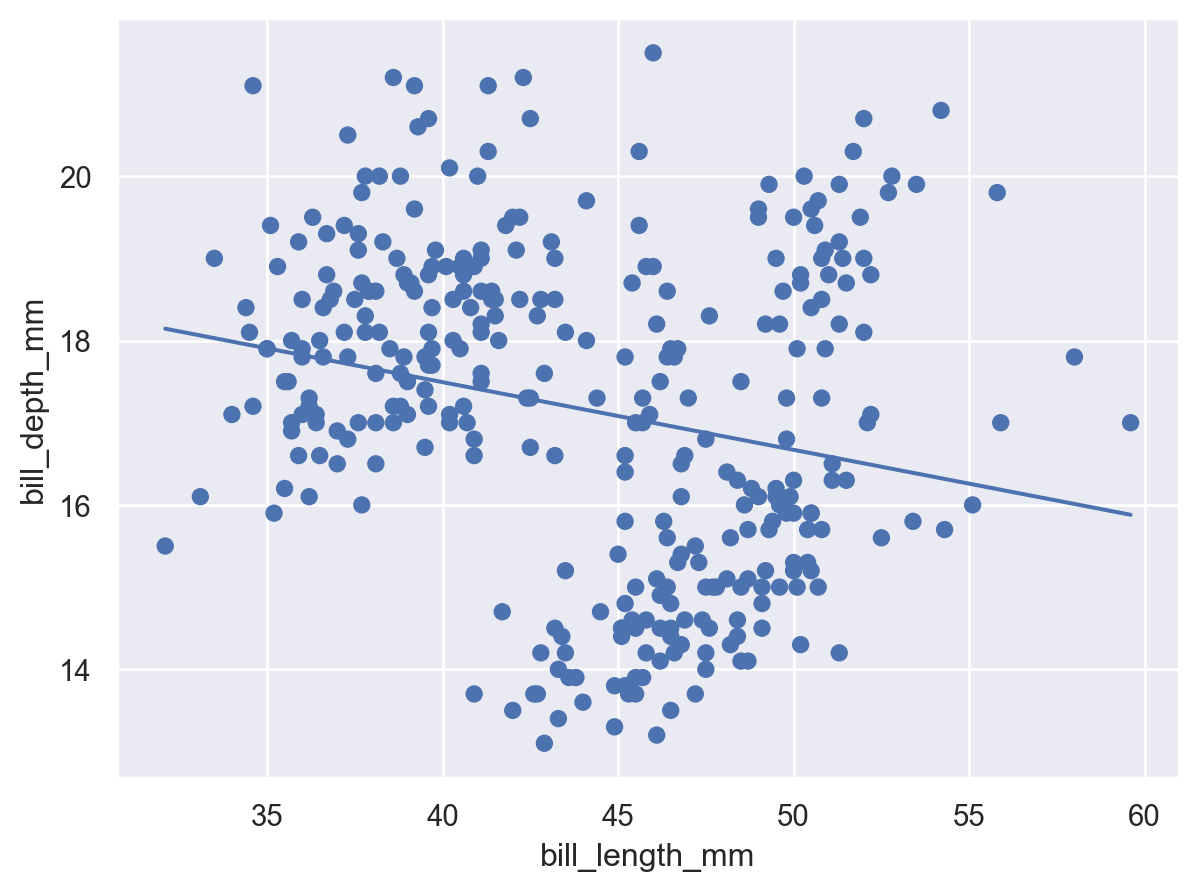

In [201]:
(
    so.Plot(data = penguins, x = "bill_length_mm", y = "bill_depth_mm")
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

El gráfico confirma la correlación negativa, pero notan algo raro? Tal vez hay algo que no estamos teniendo en cuenta?

Repetimos el gráfico coloreando los puntos según la especie.

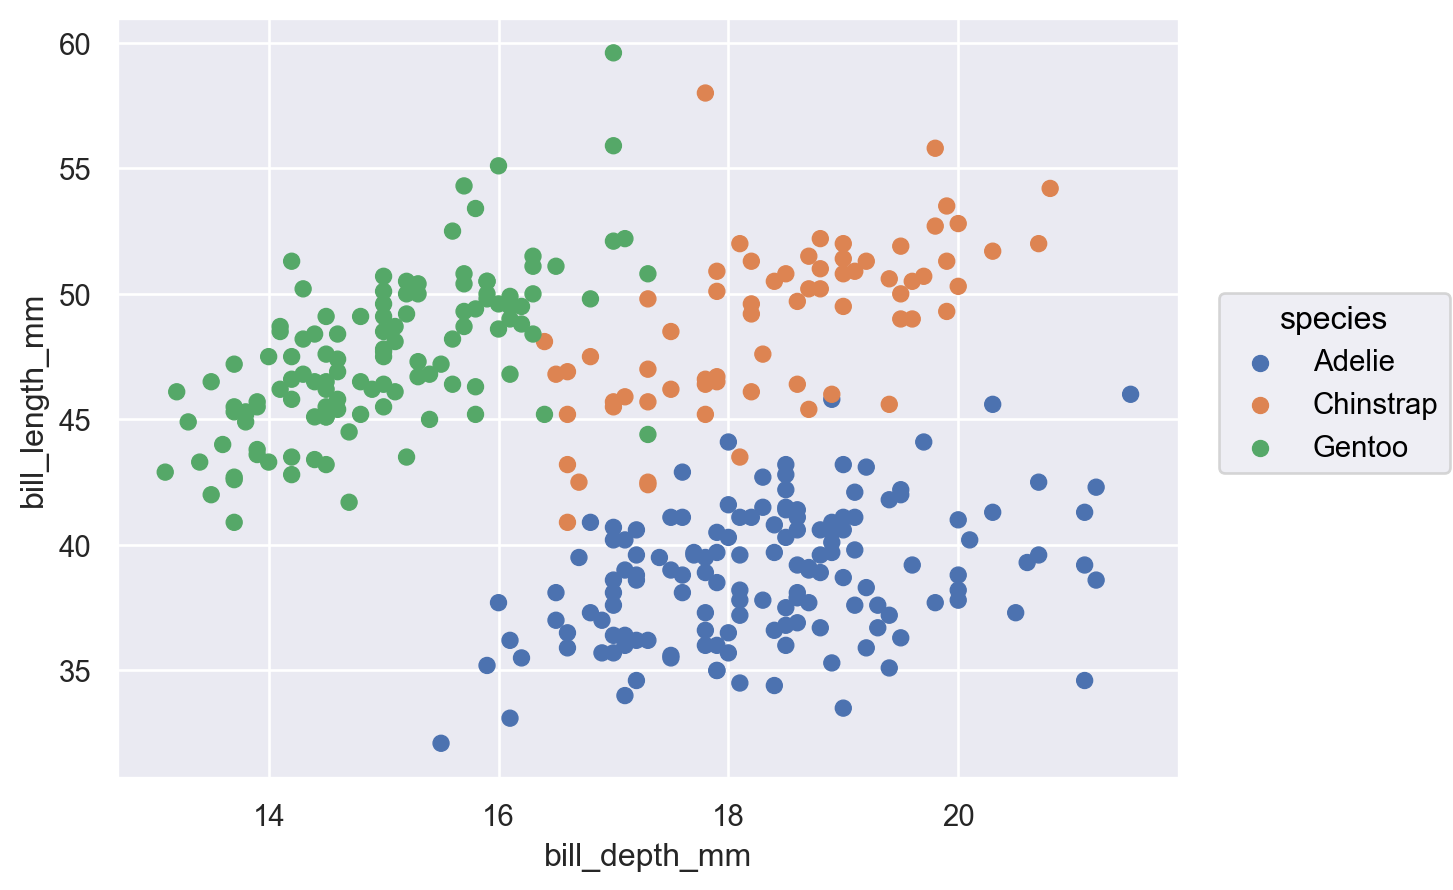

In [202]:
(
    so.Plot(data = penguins, x = "bill_depth_mm", y = "bill_length_mm", color = "species")
    .add(so.Dot())
)

En este gráfico por especie vemos dentro de cada especie puede haber correlación. Verificamos agregando los ajustes por especie.

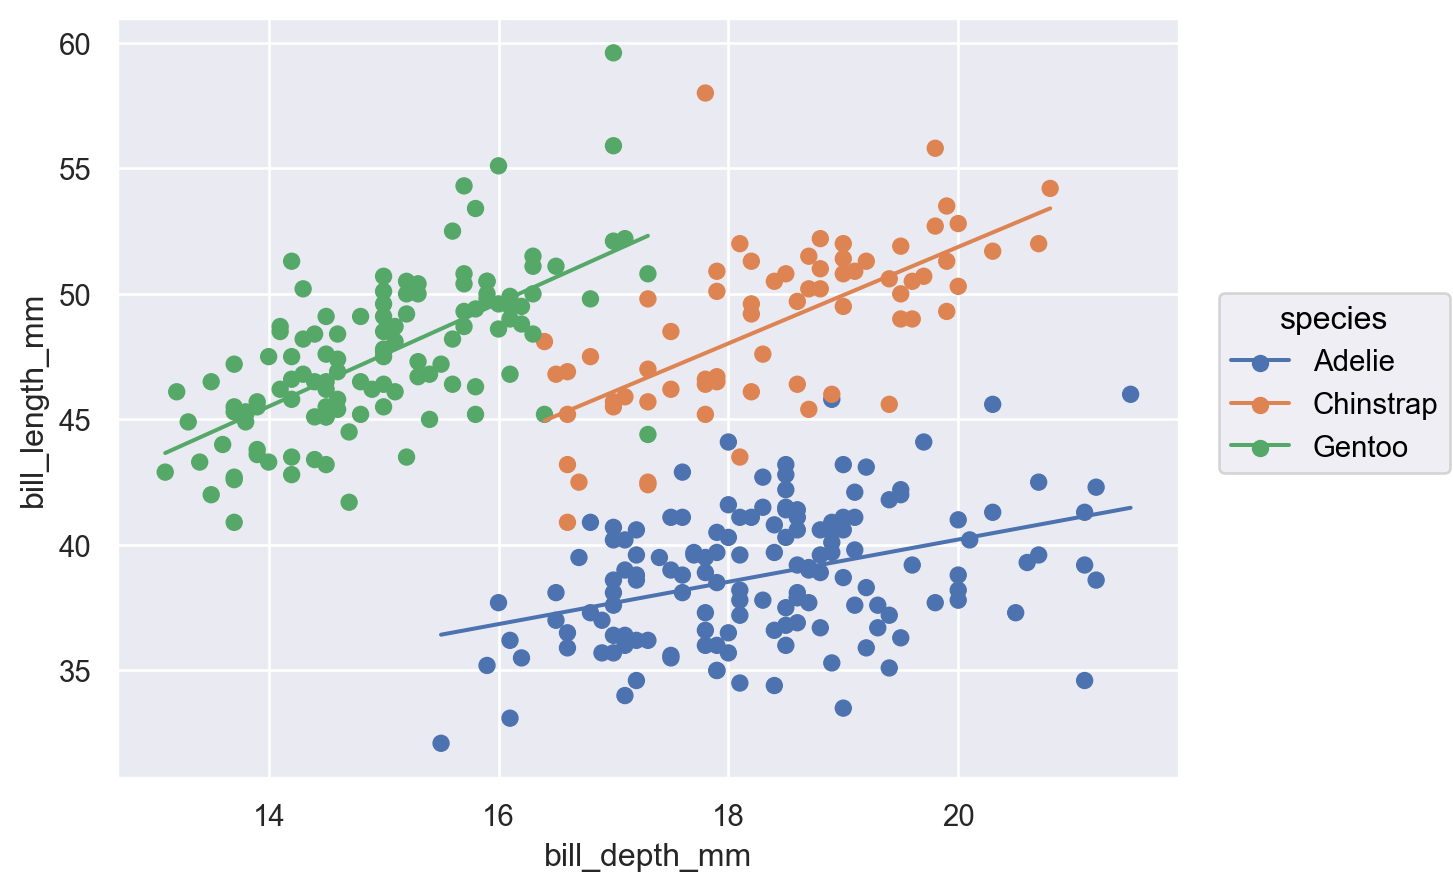

In [203]:
(
    so.Plot(data = penguins, x = "bill_depth_mm", y = "bill_length_mm", color = "species")
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

Ahora las rectas tienen pendiente positiva! Al considerar todas las especies al mismo tiempo, no podíamos ver esta correlación.

## La paradoja de Simpson
La paradoja de Simpson es un fenómeno estadístico en el cual una relación entre variables aparece, desaparece o se revierte al dividir a la población en subpoblaciones.

**Ejemplo.** Veamos otro ejemplo simulado.
Generamos dos poblaciones distribuidas aleatoriamente alrededor de dos centros.

In [204]:
from sklearn.datasets import make_blobs
centers = [[2, 2], [-2, -2]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
x = X[:,0]
y = X[:,1]

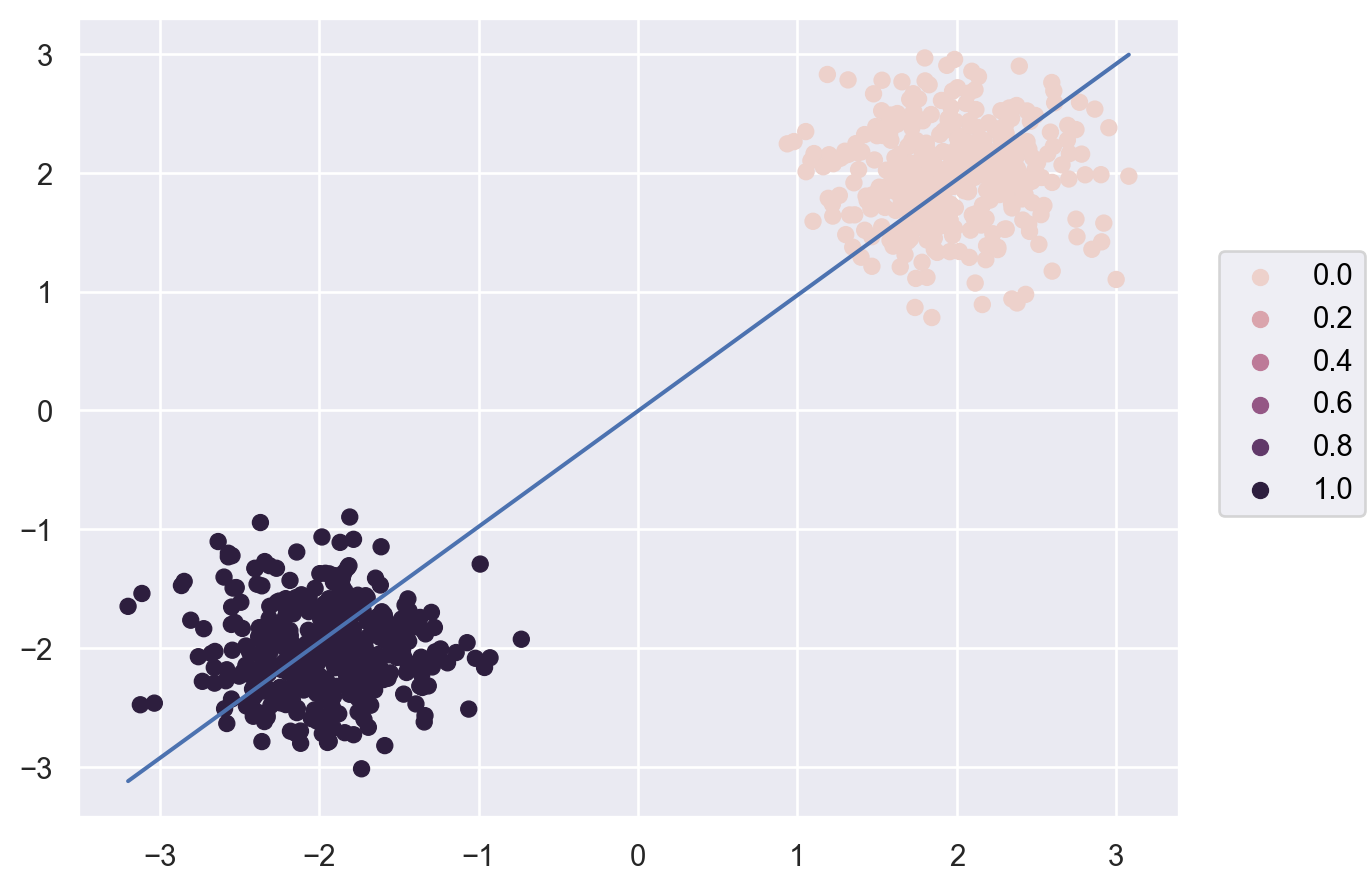

In [205]:
(
    so.Plot(x = x, y = y)
    .add(so.Dot(), color = labels_true)
    .add(so.Line(), so.PolyFit(1))
)

En este ejemplo, podríamos decir que hay correlación entre la variable x y la variable y?

Calculemos el R^2...

In [206]:
modelo = linear_model.LinearRegression()    # Inicializamos un modelo de Regresion Lineal
modelo.fit(pd.DataFrame(x), y)   # Realiza

print("Coeficientes:", modelo.coef_)

# Medidas de bondad

y_pred = modelo.predict(pd.DataFrame(X[:,0]))

# Calculando el R^2
r2 = r2_score(X[:,1], y_pred)
print('R^2: ', r2)

Coeficientes: [0.97356812]
R^2:  0.9255602605070439


Los datos parecen altamente correlacionados. Pero si separamos por grupo...

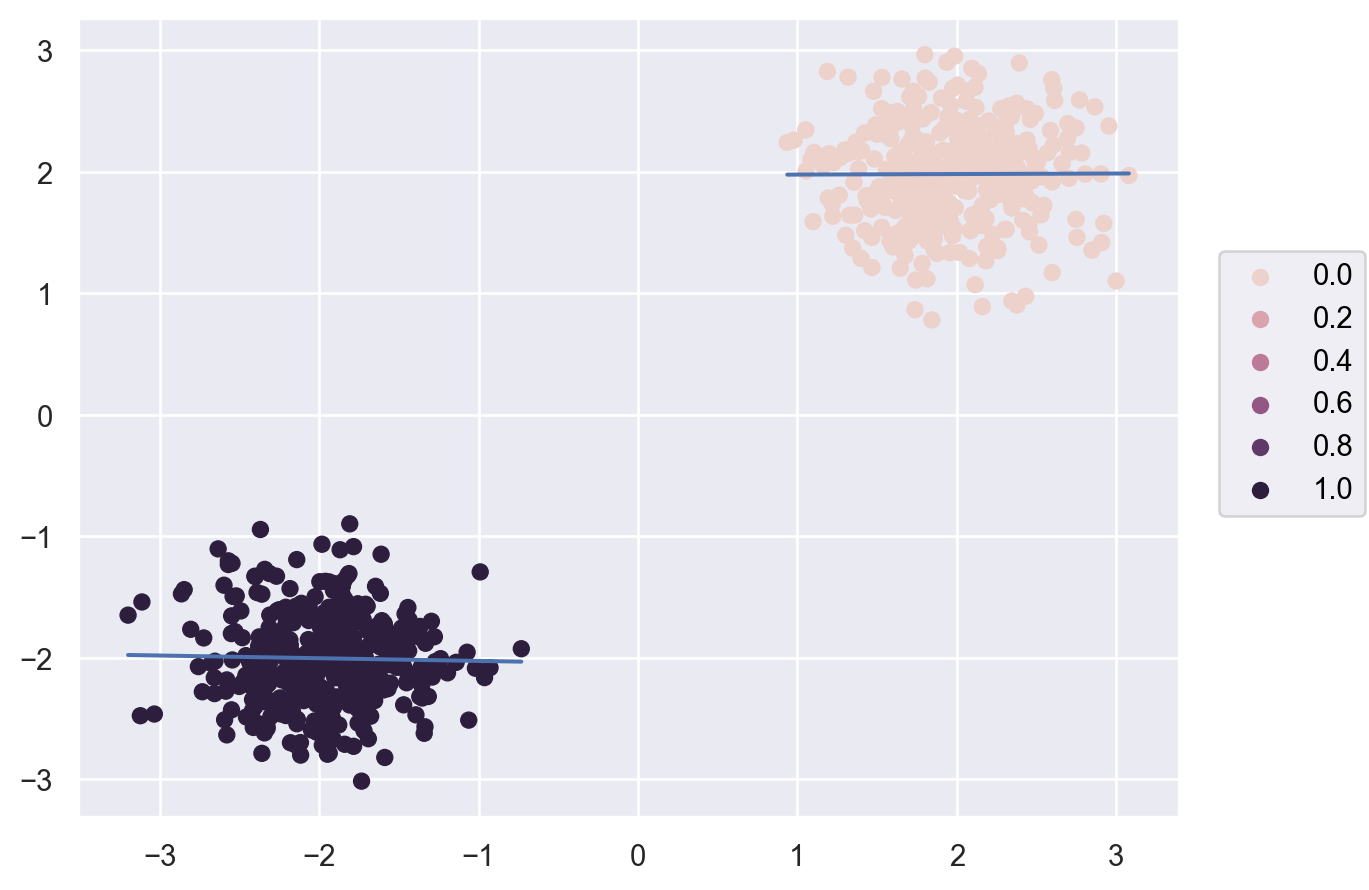

In [207]:
(
    so.Plot(x = x, y = y)
    .add(so.Dot(), color = labels_true)
    .add(so.Line(), so.PolyFit(1), group = labels_true)
)

Cómo podemos construir nosotros estos modelos?

In [208]:
y, X = Formula("bill_length_mm ~ (1 + bill_depth_mm) : species - 1").get_model_matrix(penguins)
display(X)

,species[T.Adelie],species[T.Chinstrap],species[T.Gentoo],bill_depth_mm:species[T.Adelie],bill_depth_mm:species[T.Chinstrap],bill_depth_mm:species[T.Gentoo]
0,1,0,0,18.7,0.0,0.0
1,1,0,0,17.4,0.0,0.0
2,1,0,0,18.0,0.0,0.0
4,1,0,0,19.3,0.0,0.0
5,1,0,0,20.6,0.0,0.0
...,...,...,...,...,...,...
338,0,0,1,0.0,0.0,13.7
340,0,0,1,0.0,0.0,14.3
341,0,0,1,0.0,0.0,15.7
342,0,0,1,0.0,0.0,14.8


In [209]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

Coeficientes: [[23.3668186  13.42790759 16.67018134  0.8424775   1.92208389  2.06032076]]


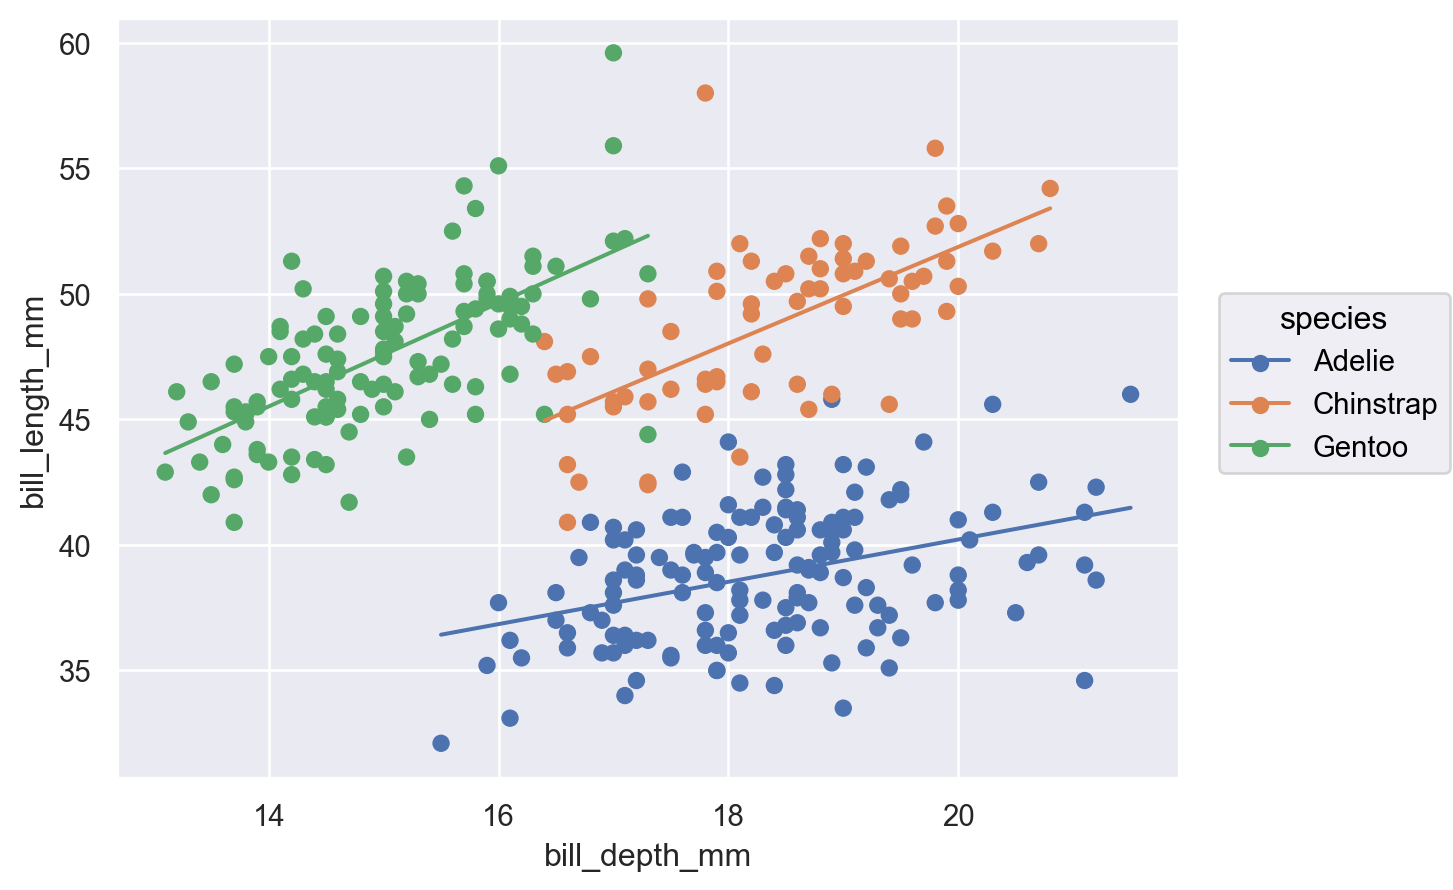

In [225]:
# Los últimos tres números son las pendientes de las rectas.
# Cómo podemos graficar este modelo?

y_pred = modelo.predict(X)

(
    so.Plot(data = penguins, x = "bill_depth_mm", y = "bill_length_mm", color = "species")
    .add(so.Dot())
    .add(so.Line(), x="bill_depth_mm", y = y_pred[:,0])  # Es un milagro!! No le tenía ninguna fe a esto :)
)

**Ejercicio.** Realizar ahora un modelo donde todas las rectas tengan la misma pendiente y solo cambie el intercept según la especie.